# Tarea 2 - Procesamiento distribuido y redes neuronales profundas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torchvision
import PIL
from scipy.stats import bernoulli
from PIL import Image
from torchvision import models, datasets, transforms
from keras.applications.imagenet_utils import decode_predictions
from skimage.segmentation import slic, mark_boundaries
from skimage.io import imshow
from sklearn.metrics import pairwise_distances, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
%matplotlib inline
# Path del directorio
path_dir = os.getcwd() + '/drive/My Drive/MA6202/T2'
os.chdir(path_dir)
# Se asigna un valor de reproductibilidad
torch.manual_seed(6202)
np.random.seed(seed=6202)

Using TensorFlow backend.


In [3]:
os.getcwd()

'/content/drive/My Drive/MA6202/T2'

## P3. Interpretabilidad 

### 1

In [4]:
# Se genera el esquema de procesamiento
preprocesamiento = transforms.Compose([transforms.Resize(size=299, interpolation=2),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225], 
                                                          inplace=True)
                                     ])

### 2

In [5]:
#modelo = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
modelo = models.inception_v3(pretrained=True)
modelo.eval();

In [6]:
#Se trabaja con la GPU para mayor eficiencia:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
dev

device(type='cuda')

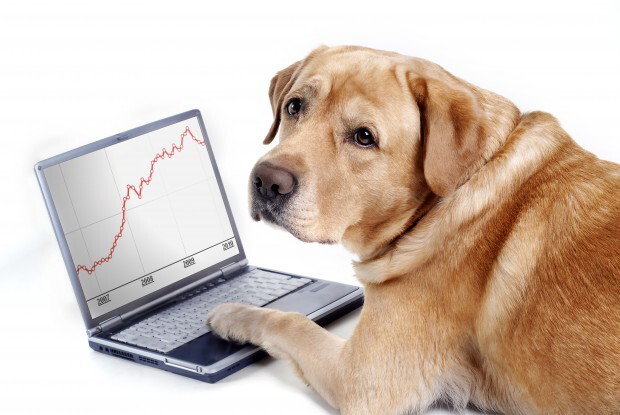

In [7]:
# Se carga la imagen de control
imagen_control = Image.open("imagen_control.jpg")
imagen_control

In [8]:
# Se procesa la imagen de control bajo el preprocesador antes creado
imagen_procesada = preprocesamiento(imagen_control)
imagen_procesada

tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2318,  2.2318,  2.2318,  ...,  2.2318,  2.2318,  2.2318],
         ...,
         [ 2.2489,  2.2489,  2.2489,  ...,  0.2624,  0.3652,  0.3994],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.2282,  0.3481,  0.3652],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.1939,  0.2967,  0.3309]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4111,  2.4111,  2.4111,  ...,  2.4111,  2.4111,  2.4111],
         ...,
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0049,  0.0826,  0.1352],
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0399,  0.0826,  0.1001],
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0749,  0.0301,  0.0651]],

        [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
         [ 2.6400,  2.6400,  2.6400,  ...,  2

In [9]:
imagen_procesada.shape

torch.Size([3, 299, 299])

In [10]:
# Se genera la red para procesar la imagen de control
input_batch = imagen_procesada.unsqueeze(0) # create a mini-batch as expected by the model

# mueve el input y modelo a la GPU en caso de estar disponible
input_batch = input_batch.to(dev)
modelo.to(dev)

# arreglo de largo 1000, con scores de confianza sobre más de 1000 clases de Imagenet
output = modelo(input_batch)

# Se normalizan los scores para obtener probabilidades.
predicciones = torch.nn.functional.softmax(
    output[0], dim=0).cpu().detach().numpy().reshape([-1,1]).T

La clase más probable es Labrador_retriever, con una probabilidad de 0.72.

In [11]:
decode_predictions(predicciones)

[[('n02099712', 'Labrador_retriever', 0.7240357),
  ('n03832673', 'notebook', 0.021590864),
  ('n02087394', 'Rhodesian_ridgeback', 0.017078103),
  ('n02099601', 'golden_retriever', 0.016017692),
  ('n03642806', 'laptop', 0.012681242)]]

In [12]:
# Se recupera la clase predicha por la red sobre la imagen de control
prediccion_control = decode_predictions(predicciones)[0][0][1] # Labrador_retriever
prediccion_control

'Labrador_retriever'

### 3

In [13]:
# Se reajustan las dimensiones de la imagen procesada para ser procesada como
# ndarray por slic(). Tensor(C,H,W) -> ndarray(H,W,C)
imagen_procesada = np.transpose(imagen_procesada.numpy(),[1,2,0])
imagen_procesada.shape

(299, 299, 3)

In [14]:
# Se procesa la imagen a traves de slic()
imagen_segmentada = slic(imagen_procesada,n_segments=80)
imagen_segmentada.shape

(299, 299)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


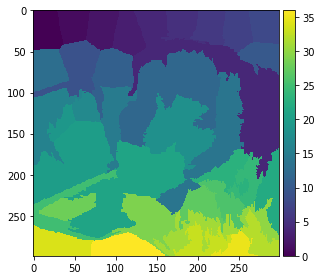

In [15]:
# Visualizamos primero los labels de la segmentación
imshow(imagen_segmentada)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


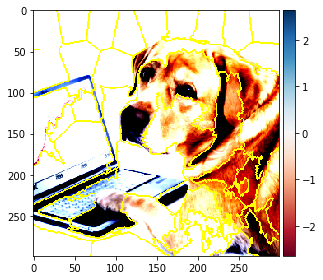

In [16]:
# Visualizamos la imagen de control con los bordes inducidos por los superpixeles. 
imshow(mark_boundaries(image=imagen_procesada,label_img=imagen_segmentada))

### 4

In [17]:
# Obtenemos los label únicos.
print(np.unique(imagen_segmentada))
print(len(np.unique(imagen_segmentada)))

# Notamos que van de 0 a 36. Luego son un total de 37 labels.
n_superpixeles = len(np.unique(imagen_segmentada))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
37


In [18]:
# Número de perturbaciones a realizar
n_perturbaciones = 1000 

# Se construye el arreglo de perturbaciones
perturbaciones = bernoulli.rvs(0.5, loc=0, size=(n_perturbaciones,n_superpixeles))

# Notamos que son 1000 perturbaciones distintas para los 37 labels
print(perturbaciones.shape)

# Vemos una de las perturbaciones
print(perturbaciones[0])

(1000, 37)
[0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1]


### 5

In [19]:
def perturbar_imagen(imagen,perturbacion,segmentacion):
  '''Perturba una imagen ndarray.
  
  Genera un ndarray de dimensiones imagen.shape donde los canales de color
  de sus pixeles según el arreglo perturbacion.

  Args
  ----

  imagen: numpy ndarray
    Imagen a perturbar

  perturbacion: numpy array
    Vector binario que indica los superpixeles considerados. 1 para los que se 
    consideran, 0 los que no.

  segmentacion: numpy ndarray
    Matriz de superpixeles asociados a cada pixel de la imagen.

  Returns
  -------
  imagen_perturbada: numpy ndarray
    Imagen perturbada según el arreglo `perturbacion`.

  '''

  superpixeles_activos = np.where(perturbacion == 1 )[0]
  mascara = np.zeros(segmentacion.shape)

  for superpixel in superpixeles_activos:
    mascara[segmentacion == superpixel] = 1

  imagen_perturbada = copy.deepcopy(imagen)
  imagen_perturbada = imagen_perturbada*mascara[:,:,np.newaxis]

  return imagen_perturbada

In [20]:
# Se genera un arreglo de imagenes perturbadas según el arreglo perturbaciones.
imagenes_perturbadas = np.array([perturbar_imagen(
    imagen_procesada,perturbacion,imagen_segmentada) for perturbacion in perturbaciones])

imagenes_perturbadas.shape

(1000, 299, 299, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'perturbaciones[2]')

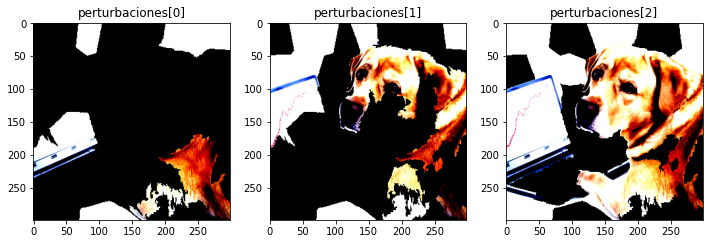

In [21]:
# Se muestran las 3 primeras perturbaciones de la imagen de control procesada
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=[12,13])

ax[0].imshow(imagenes_perturbadas[0])
ax[0].set_title('perturbaciones[0]')

ax[1].imshow(imagenes_perturbadas[1])
ax[1].set_title('perturbaciones[1]')

ax[2].imshow(imagenes_perturbadas[2])
ax[2].set_title('perturbaciones[2]')

### 6

In [22]:
def acierto(prediccion, prediccion_control):
  ''' Retorna 1 en caso de coincidir con la prediccion de la imagen de control
  y 0 si no. 
  '''
  return 1 if prediccion == prediccion_control else 0

In [23]:
def prediccion(imagen):
  '''Realiza una prediccion sobre la imagen retorna un string con el
  nombre de la clase más probable.

  '''
  # Se setea el input_batch para entrar a la red y predecir su label
  input_batch = torch.from_numpy(np.transpose(imagen,[2,0,1])).unsqueeze(0)
  input_batch = input_batch.to(dev, dtype=torch.float)

  # Se calculan las probabilidades de cada clase
  output = modelo(input_batch)
  predicciones = torch.nn.functional.softmax(
    output[0], dim=0).cpu().detach().numpy().reshape([-1,1]).T

  # Se recupera la clase más probable
  prediccion = decode_predictions(predicciones)[0][0][1]
  
  return prediccion

In [24]:
# Se crea el vector y
y = np.array([acierto(prediccion(imagenes_perturbadas[i]),prediccion_control)
for i in range(n_perturbaciones)])
print('Cantidad de predicciones acertadas: {}'.format(sum(y)))

Cantidad de predicciones acertadas: 416


### 7

In [25]:
# Se crea un arreglo de 1's que corresponde a "no perturbar" la imagen original
imagen_original = np.ones(n_superpixeles).reshape(1,-1)
imagen_original

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.]])

In [26]:
# Se calculan las distancias coseno
distancias = 1 - pairwise_distances(perturbaciones,imagen_original, metric='cosine').ravel()
print(distancias.shape)

(1000,)


In [27]:
# Se calcula pi_x
sigma = 0.25
pi_x = np.exp(-(distancias**2)/sigma**2)
print(pi_x.shape)

(1000,)


### 8

In [28]:
# Se genera el conjunto de entrenamiento D_p concatenando el vector y sobre
# el arreglo de perturbaciones
D_p = np.column_stack([perturbaciones,y])
D_p.shape

(1000, 38)

### 9

In [29]:
# Se obtienen los datos de entrenamiento
X_train = D_p[:,:-1]
y_train = D_p[:,-1:].ravel()

# Se crea el modelo de regresión logística y se ajusta a los datos de entrenamiento 
modelo_logistico = LogisticRegression()
modelo_logistico.fit(X=X_train, y=y_train, sample_weight=pi_x)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

En este caso donde estamos empleando LIME en base a un modelo de regresión logística, lo que busca este modelo es correlacionar una variable binaria(predecir bien la clase en la imagen de control) con una variable explicativa X, esto es, las perturbaciones/máscaras. La funcion de probabilidad es aproximada entonces por una función logística de la forma de una sigmoide como sigue: 

$$ \frac{1}{1+e^{-{\pi_x \cdot}x}} = \frac{1}{1+e^{-{\sum_{i=1}^{N} \omega_{i}x_{i}}}}$$

Luego los coeficientes más grándes representan los superpixeles que más influyen en la predicción de la clase obtenida de la imagen de control. 

Así, incluyendo el hecho de que para el metodo $\texttt{.fit_predict}$ de $\texttt{LogisticRegression}$ no permite agregar argumentos sumados además de la función de pesos, luego no es posible discriminar de manera general la cantidad de superpixeles de soporte. Tenemos entonces que para el contexto de regresión logística no es necesario agregar tal medida de complejidad $\Omega(g)$. 

Sin embargo, cambiando el esquema de optimización es posible implementar una función objetivo que permita dimensionar la complejidad de $\Omega(g)$, por ejemplo, la cantidad de superpixeles que tiene la representación interpretable, de manera que ésta no presente "pesos" en todas sus componentes y se obtenga una representación más evidente de la predicción. 


### 10

In [30]:
def visualizacion_lime(imagen,labels,coeficientes,N):
  '''Obtiene imagenes perturbadas con las perturbaciones asociadas a los
  superpixeles con los N pesos más grandes y N más pequeños. Genera una visualización
  de éstas imágenes.

  Args
  ----

  imagen: numpy ndarray
    Imagen a procesar mediante las perturbaciones

  labels: numpy_ndarray
    Matriz de superpixeles asociados a cada pixel de la imagen.

  coeficientes: numpy array
    Arreglo con los pesos asociados a cada superpixel.

  N: Int
    Número de superpixeles a considerar en la visualización.   
  
  Returns
  -------
  imagen_mascara_mejores: numpy ndarray
    Imagen perturbada con los N labels con mayores pesos.

  imagen_mascara_peores: numpy ndarray
    Imagen perturbada con los N labels con menores pesos.
  
  '''
  
  n_superpixeles = len(labels)
  
  mejores_superpixeles = np.argsort(coeficientes)[-N:][::-1]
  pesos_mejores_superpixeles = coeficientes[mejores_superpixeles]
  peores_superpixeles = np.argsort(coeficientes)[:N]
  pesos_peores_superpixeles = coeficientes[peores_superpixeles]
  print("Superpixeles de mayor peso: ", mejores_superpixeles)
  print("Pesos: ", pesos_mejores_superpixeles)
  print("Superpixeles de menor peso: ", peores_superpixeles)
  print("Pesos: ", pesos_peores_superpixeles)

  # Se crea una perturbacion mascara con los mejores_superpixeles
  mascara_mejores, mascara_peores = np.zeros(n_superpixeles), np.zeros(n_superpixeles) 
  mascara_mejores[mejores_superpixeles]= True #Activa los mejores superpixeles
  mascara_peores[peores_superpixeles]= True #Activa los peores superpixeles

  # Se perturba la imagen con la mascara
  imagen_mascara_mejores = perturbar_imagen(imagen_procesada, mascara_mejores, labels)
  imagen_mascara_peores = perturbar_imagen(imagen_procesada, mascara_peores, labels)

  # Se muestra la imagen 
  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12,13])
  ax[0].imshow(imagen_mascara_mejores)
  ax[0].set_title('Mejores')
  ax[1].imshow(imagen_mascara_peores)
  ax[1].set_title('Peores')

  return imagen_mascara_mejores, imagen_mascara_peores

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Superpixeles de mayor peso:  [12  4 18 29 26 13 14 10 32  6]
Pesos:  [0.06394439 0.05069873 0.05028719 0.03213657 0.02298735 0.01815374
 0.01498598 0.00916984 0.00889533 0.00781715]
Superpixeles de menor peso:  [21 28 11  2 34  8 27 24 15 19]
Pesos:  [-0.03366019 -0.02341213 -0.01599012 -0.01496869 -0.01367879 -0.013306
 -0.01265656 -0.01257646 -0.01242163 -0.01212156]


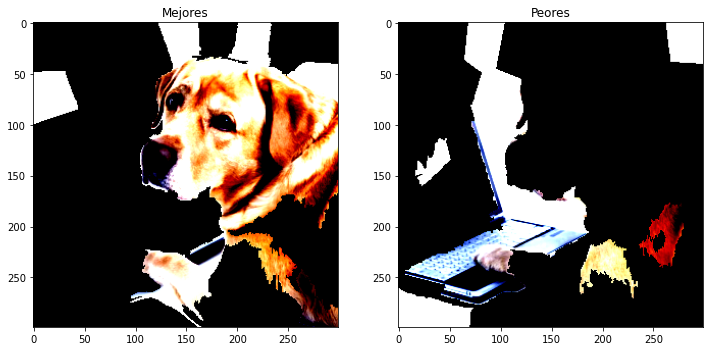

In [31]:
# Se guarda el vector con los coeficientes del ajuste anterior
coeficientes = modelo_logistico.coef_[0]

# Se genera la visualización
imagen_mascara_mejores, imagen_mascara_peores = visualizacion_lime(imagen_procesada,imagen_segmentada,coeficientes,10)

In [32]:
# Corroboramos si con los labels de mayor peso se logra predecir la clase de control
print( "Predicción mejores :",prediccion(imagen_mascara_mejores))
print( "Predicción peores :",prediccion(imagen_mascara_peores))

Predicción mejores : Labrador_retriever
Predicción peores : notebook


Notamos que filtrando los 10 superpixeles con mayor peso dentro de la regresión logística, junto con los 10 superpixeles de menor peso, incluyendo negativos pues también representan los casos donde se desfavorece la predicción de 'Labrador_retriever', obtenemos 2 representaciones de la imagen de control. De las representaciones obtenidas, se tiene que la obtenida con los pesos más alto representa la predicción de 'Labrador_retriever', luego los superpixeles asociados a tales pesos son los que más aportan en la probabilidad de pertenecer a la clase. Por otra parte, notamos que para los pesos más bajos (negativos) encontramos representaciones que desfavorecen en la predicción de la clase, donde si realizamos una predicción sobre esta representación obtenemos que su clase más probable es 'notebook'. 

Así, la regresión logistica implementada, dada una segmentación de la imagen de control, es posible representar ésta de una manera interpretable por nosotros(qué superpixeles de la imagen considerados), para obtener una descripción de la predicción, validando de ésta manera la predicción obtenida inicialmente. 

### 11

In [33]:
# Se crea un nuevo esquema de procesamiento para convertir la imagen de control
# a grayscale.
procesamiento_gs = transforms.Compose([transforms.Resize(size=299, interpolation=2),
                                     transforms.CenterCrop(299),
                                     ])

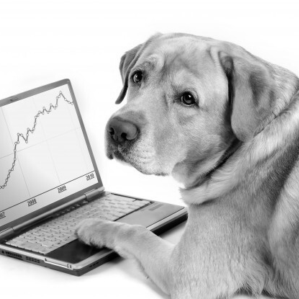

In [34]:
# Procedemos a hacer la transformacion
imagen_procesada_gs = procesamiento_gs(imagen_control)
imagen_procesada_gs = imagen_procesada_gs.convert("L")
imagen_procesada_gs

In [35]:
# La convertimos en arreglo de numpy para trabajar en la clusterizacion
imagen_procesada_gs = np.asarray(imagen_procesada_gs)
print(imagen_procesada_gs.shape)
imagen_procesada_gs

(299, 299)


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [254, 254, 254, ..., 254, 254, 254],
       ...,
       [255, 255, 255, ..., 121, 126, 129],
       [255, 255, 255, ..., 119, 126, 127],
       [255, 255, 255, ..., 117, 123, 125]], dtype=uint8)

In [36]:
# Creamos el conjunto de entrenamiento X
X = np.array( [ [i,j,imagen_procesada_gs[i,j]]
               for i in range(299) for j in range(299)])

# Notamos que tiene largo 299*299 y cada fila corresponde a una observación
# donde las primeras 2 componentes son espaciales y la tercera es el color
print(X.shape)
X

(89401, 3)


array([[  0,   0, 255],
       [  0,   1, 255],
       [  0,   2, 255],
       ...,
       [298, 296, 117],
       [298, 297, 123],
       [298, 298, 125]])

In [37]:
# Fijamos el numero de clusters como la cantidad de superpixeles obtenidos antes
# para reutilizar el arreglo de perturbaciones creado previamente
n_clusters = n_superpixeles
n_clusters

37

In [38]:
# KMeans
# Creamos el cluster KMeans con n_cluster clusters y ajustamos al conjunto de entrenamiento 
km_cluster = KMeans(n_clusters=n_clusters)
km_cluster.fit_predict(X)

# Obtenemos los labels(superpixeles) y los centros de cada cluster
km_labels, km_centers = km_cluster.labels_, km_cluster.cluster_centers_.squeeze()
print(km_labels.shape)
print(km_labels)
print(np.unique(km_labels))

(89401,)
[20 20 20 ... 21 21 21]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [39]:
# Recuperamos la estructura original de la imagen descrita por superpixeles
km_labels = km_labels.reshape(299,299)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


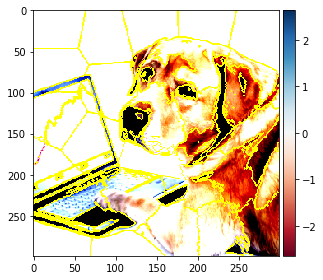

In [40]:
# Obtenemos una visualización de los bordes que inducen los superpixeles 
# obtenidos por KMeans sobre la imagen de control
imshow(mark_boundaries(image=imagen_procesada,label_img=km_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'superpixel 5')

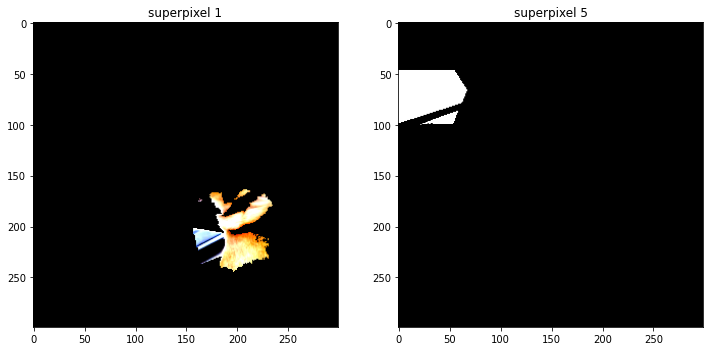

In [41]:
# Visualizamos algunos clusters obtenidos de éste metodo
i,j = 1,5
mascara_i, mascara_j = np.zeros(n_clusters),np.zeros(n_clusters)
mascara_i[i], mascara_j[j]= True, True
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12,13])
ax[0].imshow(perturbar_imagen(imagen_procesada,mascara_i,km_labels))
ax[0].set_title('superpixel {}'.format(i))
ax[1].imshow(perturbar_imagen(imagen_procesada,mascara_j,km_labels))
ax[1].set_title('superpixel {}'.format(j))

In [42]:
# MiniBatchKMeans
# Creamos el cluster MeanShift y ajustamos al conjunto de entrenamiento 
mbkm_cluster = MiniBatchKMeans(n_clusters=n_clusters, batch_size=16, random_state=0)
mbkm_cluster.fit_predict(X)

# Obtenemos los labels(superpixeles) y los centros de cada cluster
mbkm_labels, mbkm_centers = mbkm_cluster.labels_, mbkm_cluster.cluster_centers_.squeeze()
print(mbkm_labels.shape)
print(mbkm_labels)
print(np.unique(mbkm_labels))

(89401,)
[22 22 22 ... 35 35 35]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [43]:
# Recuperamos la estructura original de la imagen descrita por superpixeles
mbkm_labels = mbkm_labels.reshape(299,299)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


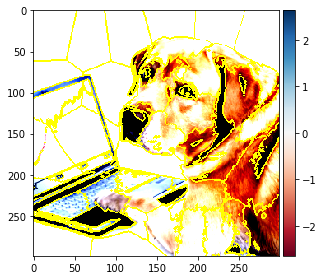

In [44]:
# Obtenemos una visualización de los bordes que inducen los superpixeles 
# obtenidos por KMeans sobre la imagen de control
imshow(mark_boundaries(image=imagen_procesada,label_img=mbkm_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Cluster 2')

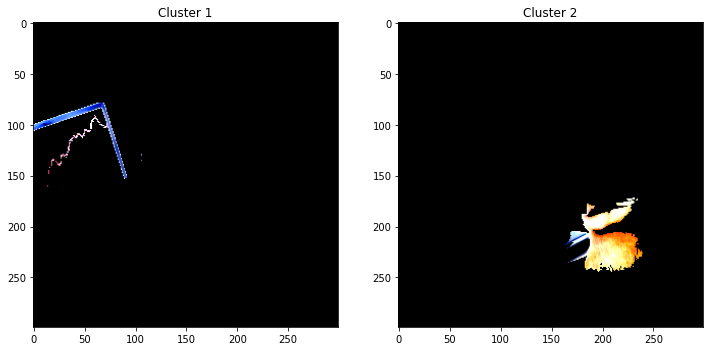

In [45]:
# Visualizamos algunos clusters obtenidos de éste metodo
i,j = 1,2
mascara_i, mascara_j = np.zeros(n_clusters),np.zeros(n_clusters)
mascara_i[i], mascara_j[j]= True, True
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12,13])
ax[0].imshow(perturbar_imagen(imagen_procesada, mascara_i, mbkm_labels))
ax[0].set_title('Cluster {}'.format(i))
ax[1].imshow(perturbar_imagen(imagen_procesada, mascara_j, mbkm_labels))
ax[1].set_title('Cluster {}'.format(j))

### 12

#### KMeans

In [46]:
# Se genera un arreglo de imagenes perturbadas según el arreglo perturbaciones.
imagenes_perturbadas_km = np.array([perturbar_imagen(
    imagen_procesada,perturbacion,km_labels) for perturbacion in perturbaciones])

imagenes_perturbadas_km.shape

(1000, 299, 299, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


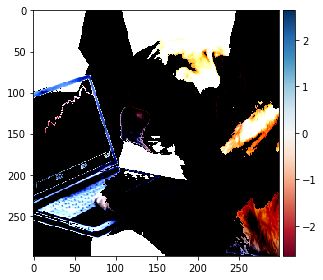

In [47]:
imshow(imagenes_perturbadas_km[8])

In [48]:
# Se crea el vector y_km
y_km = np.array([acierto(prediccion(imagenes_perturbadas_km[i]),prediccion_control)
for i in range(n_perturbaciones)])
print('Cantidad de predicciones acertadas: {}'.format(sum(y_km)))

Cantidad de predicciones acertadas: 415


In [49]:
# Se genera el conjunto de entrenamiento D_p_km concatenando el vector y sobre
# el arreglo de perturbaciones
D_p_km = np.column_stack([perturbaciones,y_km])
D_p_km.shape

(1000, 38)

In [50]:
# Se crea el modelo de regresión logística y se ajusta a los datos de entrenamiento 
modelo_logistico_km = LogisticRegression()
modelo_logistico_km.fit(X=D_p_km[:,:-1], y=D_p_km[:,-1:].ravel(), sample_weight=pi_x)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Superpixeles de mayor peso:  [31 25 32 19 11 24  7 16  0 28]
Pesos:  [0.04232228 0.03950259 0.03608843 0.02096764 0.0200231  0.01734479
 0.01685625 0.01255134 0.00754191 0.00703698]
Superpixeles de menor peso:  [ 9  4 23 29  8 22  5 36 34  1]
Pesos:  [-0.01178885 -0.0091781  -0.00732778 -0.00637788 -0.00477207 -0.00332748
 -0.0033109  -0.00325296 -0.00264547 -0.00256832]


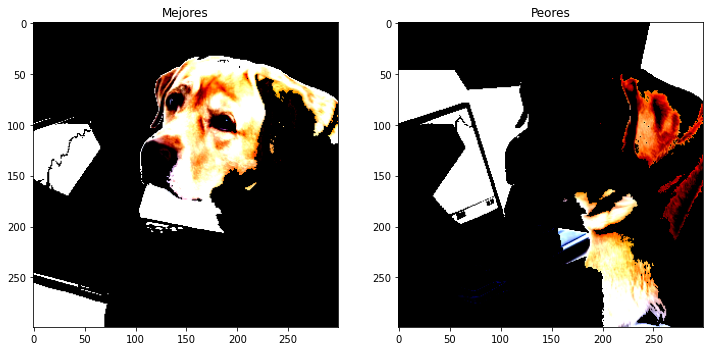

In [51]:
# Se guarda el vector con los coeficientes del ajuste anterior
coeficientes_km = modelo_logistico_km.coef_[0]

# Se genera la visualización
imagen_mascara_mejores_km, imagen_mascara_peores_km = visualizacion_lime(imagen_procesada,km_labels,coeficientes_km,10)

In [52]:
# Corroboramos si con los labels de mayor peso se logra predecir la clase de control
print( "Predicción mejores :", prediccion(imagen_mascara_mejores_km))
print( "Predicción peores :", prediccion(imagen_mascara_peores_km))

Predicción mejores : Labrador_retriever
Predicción peores : conch


Para KMeans obtenemos que la representación con los 10 superpixeles de mayor peso en la regresión logística son clasificados como 'Labrador_retriever', donde a partir de la visualización es facil notar el por qué de la elección, ésta rescata los aspectos más característicos dentro de una raza de perro, esto es, las formas del hocico, las orejas y cráneo. Notamos además que para los 10 superpixeles con menor peso se obtiene como predicción 'conch', que corresponde a las conchas de mar, esto puede deberse a que entre los superpixeles considerados, el tercer y quinto más negativos (la oreja y el cuello) presentan una forma similar a la de una concha boca abajo, luego el clasificador pudo haber considerado como importantes esos pixeles de la imagen para hacer la predicción.

#### MiniBatchKMeans

In [53]:
# Se genera un arreglo de imagenes perturbadas según el arreglo perturbaciones.
imagenes_perturbadas_mbkm = np.array([perturbar_imagen(
    imagen_procesada,perturbacion,mbkm_labels) for perturbacion in perturbaciones])

imagenes_perturbadas_mbkm.shape

(1000, 299, 299, 3)

In [54]:
# Se crea el vector y_km
y_mbkm = np.array([acierto(prediccion(imagenes_perturbadas_mbkm[i]),prediccion_control)
for i in range(n_perturbaciones)])
print('Cantidad de predicciones acertadas: {}'.format(sum(y_mbkm)))

Cantidad de predicciones acertadas: 474


In [55]:
# Se genera el conjunto de entrenamiento D_p_mbkm concatenando el vector y sobre
# el arreglo de perturbaciones
D_p_mbkm = np.column_stack([perturbaciones,y_mbkm])
D_p_mbkm.shape

(1000, 38)

In [56]:
# Se crea el modelo de regresión logística y se ajusta a los datos de entrenamiento 
modelo_logistico_mbkm = LogisticRegression()
modelo_logistico_mbkm.fit(X=D_p_mbkm[:,:-1], y=D_p_mbkm[:,-1:].ravel(), sample_weight=pi_x)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Superpixeles de mayor peso:  [ 7 32 36 20  3 23 10 11 22 21]
Pesos:  [0.05384068 0.04340751 0.02722257 0.02458542 0.0214704  0.01764627
 0.01136538 0.01100284 0.01014261 0.00956773]
Superpixeles de menor peso:  [ 8 31 15  6 18 29 24  9 13 34]
Pesos:  [-0.01941318 -0.01913342 -0.01781288 -0.01486962 -0.01414541 -0.01237603
 -0.011038   -0.01053635 -0.01052167 -0.0086082 ]


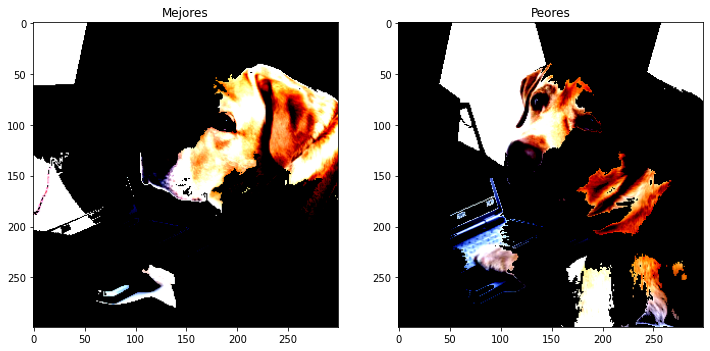

In [57]:
# Se guarda el vector con los coeficientes del ajuste anterior
coeficientes_mbkm = modelo_logistico_mbkm.coef_[0]

# Se genera la visualización
imagen_mascara_mejores_mbkm, imagen_mascara_peores_mbkm = visualizacion_lime(imagen_procesada,mbkm_labels,coeficientes_mbkm,10)

In [58]:
# Corroboramos si con los labels de mayor peso se logra predecir la clase de control
print( "Predicción mejores :",prediccion(imagen_mascara_mejores_mbkm))
print( "Predicción peores :",prediccion(imagen_mascara_peores_mbkm))

Predicción mejores : Labrador_retriever
Predicción peores : Italian_greyhound


Para MiniBatchKMeans tenemos que la representación con los 10 superpixeles de mayor peso obtienen la predicción esperada, es decir, 'Labrador_retriever'. Notamos que este método de clusterización logró captar el hocico y orejas en la imagen, lo cual ciertamente influyó en la predicción. Además si consideramos los 10 superpixeles de menor peso(negativos incluidos) tenemos que se obtiene como predicción 'Italian_greyhound', perro de pelaje claro y hocico delgado, como muestra la representación. 

### 13